In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.nn import Parameter
import torchvision

import os
import matplotlib.pyplot as plt
import numpy as np

from model import AutoEncoder, LatentAutoEncoder
from tqdm import tqdm_notebook

In [3]:
EPOCH = 100
BATCH_SIZE = 100

In [4]:
sigmas = np.arange(0.01, 0.1, 0.01)

In [7]:
autoencoders = []
PATH = 'saved_models/comparison/min-max/'
paths = [path for path in sorted(os.listdir(PATH)) if '.ipynb_checkpoints' not in path]
for model_path, sigma in zip(paths, sigmas):
    if '.ipynb_checkpoints' in model_path: continue
    model = LatentAutoEncoder(2, 'min-max', sigma=sigma).cuda()
    model.set_device(); model.eval()
    checkpoint_dict = torch.load(os.path.join(PATH, model_path), map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    autoencoders.append(model)

In [8]:
train_data = torchvision.datasets.MNIST(
    root='datasets/mnist/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=False,
)

In [9]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
autoencoders = []
for sigma in tqdm_notebook(sigmas):
    latent_ae = LatentAutoEncoder(2, 'min-max', sigma=sigma).cuda()
    latent_ae.set_device()
    optimizer = torch.optim.Adam(latent_ae.parameters(), lr=0.001)
    loss_func = nn.MSELoss()
    for epoch in range(EPOCH):
        for step, (x, _) in enumerate(train_loader):
            optimizer.zero_grad()

            x_batch = x.view(-1, 28 * 28).cuda()
            y_batch = x.view(-1, 28 * 28).cuda()

            _, latent, transformed, decoded = latent_ae(x_batch)

            loss = torch.nn.functional.cross_entropy(decoded, y_batch) 
            loss += torch.nn.functional.mse_loss(transformed, latent)
            loss.backward()
            optimizer.step()
    autoencoders.append(latent_ae.cpu())

In [34]:
# for i, (ae, sigma) in enumerate(zip(autoencoders, sigmas)):
#     torch.save({'state_dict': ae.state_dict()}, f'./saved_models/min-max/ae_m_sig_{np.round(sigma, 3)}')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


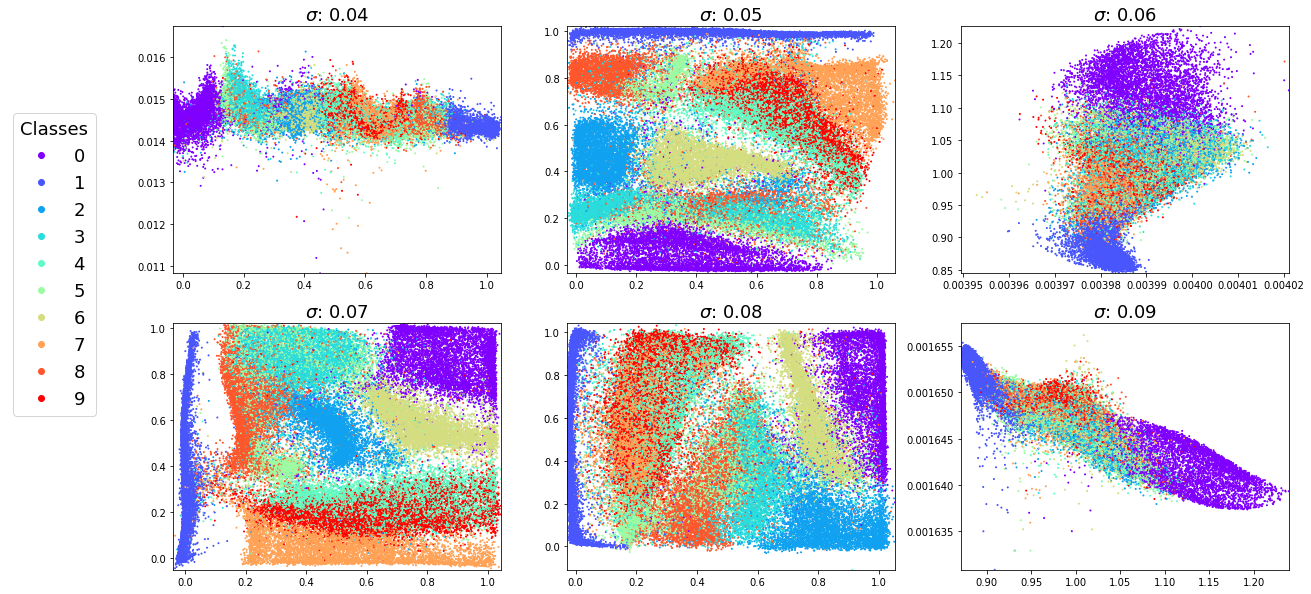

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
# plt.suptitle('Normalization: Min-Max', fontsize=20)
view_data = train_data.data.view(-1, 28 * 28).type(torch.FloatTensor) / 255.
legends = []
for i, (ae, sigma, ax) in enumerate(zip(autoencoders[3:], sigmas[3:], axes.flat)):
    _, encoded_data, _, _ = ae(view_data.cuda())
    X, Y = encoded_data[:, 0].detach().cpu(), encoded_data[:, 1].detach().cpu()
    sc = ax.scatter(X, Y, c=train_data.targets.numpy(), cmap='rainbow', s=1);
    ax.set_title(f'$\sigma$: {np.round(sigma, 3)}', fontsize=18);
    ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max());
fig.legend(*sc.legend_elements(), title="Classes", loc=(0.01, 0.3), fontsize=18, title_fontsize=18);
plt.savefig('pics/latent_space/min-max.png')

In [40]:
test_data = torchvision.datasets.MNIST(
    root='datasets/mnist/',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=False,
)

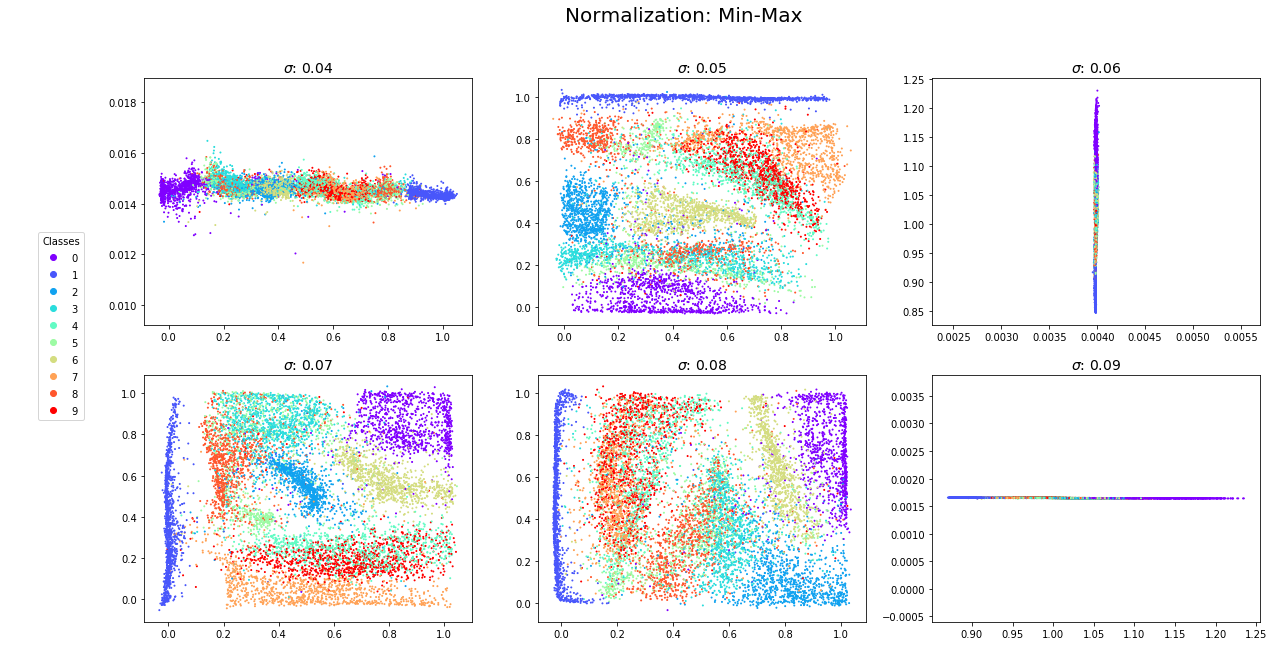

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.suptitle('Normalization: Min-Max', fontsize=20)
view_data = test_data.data.view(-1, 28 * 28).type(torch.FloatTensor) / 255.
legends = []
for i, (ae, sigma, ax) in enumerate(zip(autoencoders[3:], sigmas[3:], axes.flat)):
    _, encoded_data, _, _ = ae.cuda()(view_data.cuda())
    sc = ax.scatter(encoded_data[:, 0].detach().cpu(), encoded_data[:, 1].detach().cpu(), 
                    c=test_data.targets.numpy(), cmap='rainbow', s=1);
    ax.set_title(f'$\sigma$: {np.round(sigma, 3)}', fontsize=14);
fig.legend(*sc.legend_elements(), title="Classes", loc=(0.03, 0.35));